# Necessary Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.utils import estimator_html_repr
from sklearn.base import BaseEstimator

import time
import re

# Necessary Functions

In [5]:
def accuracy_score(y_pred, y_test):
    """
    To calculate the accuracy score.
    Accuracy = number of correctly classified examples / number of examples

    Parameters
    ----------
    y_pred: np.ndarray
        A list of the y predicted values from the naive bayes model

    y_test: np.ndarray
        A list of the y test values to compare to the predicted values

    Returns
    -------
    accuracy_score: float
        The accuracy score. Between 0 and 1
    """
    if y_pred.shape != y_test.shape:
        raise ValueError("Cannot accept two datasets with different shapes.")
    unique, counts = np.unique(y_pred == y_test, return_counts=True)
    n_samples = y_pred.shape
    accuracy_score = counts[1] / n_samples
    return accuracy_score[0]

def preprocess_text(text):
    """
    Clean the text unecessary space, symbols, single-letter words.

    Parameters
    ----------
    text: str
        The text to preprocess

    Returns
    -------
    text: str
        The preprocessed texxt
    """
    text = text.lower()
    stopwords = "|".join([re.escape(w) for w in list(ENGLISH_STOP_WORDS)])
    pattern_remove_short = rf"\b(?!{stopwords}$)\w{{2}}\b"
    text = re.sub(r"(?<=\d)(?=\D)|(?<=\D)(?=\d)", " ", text) # Seperate Numbers
    text = re.sub(r"\b[b-z]\b", "", text) # Remove 1-length strings except "a" since it is a stopword
    text = re.sub(pattern_remove_short, "", text) # Remove 2-length strings except stopwords
    text = re.sub(r"[^a-z$]"," ",text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def encode(data):
    """
    To label encode a column.

    Parameters
    ----------
    data: np.ndarray
        A 1D numpy array that has categorical values.

    Returns
    -------
    data_copy: np.ndarray
        Integer based column where each integer
        represents the encoded category.

    Notes
    -----
    - The encoded values are the indices of the unique categorical values
    from the original data.
    """
    unique = np.unique(data)
    data_copy = data.copy()
    for index, val in enumerate(unique):
        data_copy[data_copy == val] = index
    return data_copy.astype(int)

## Part I - Understanding the Data

In [6]:
data_directory = "data/"

In [7]:
df = pd.read_csv(data_directory + "English Dataset.csv")
df = df.drop("ArticleId", axis=1)

In [8]:
df.head()

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business


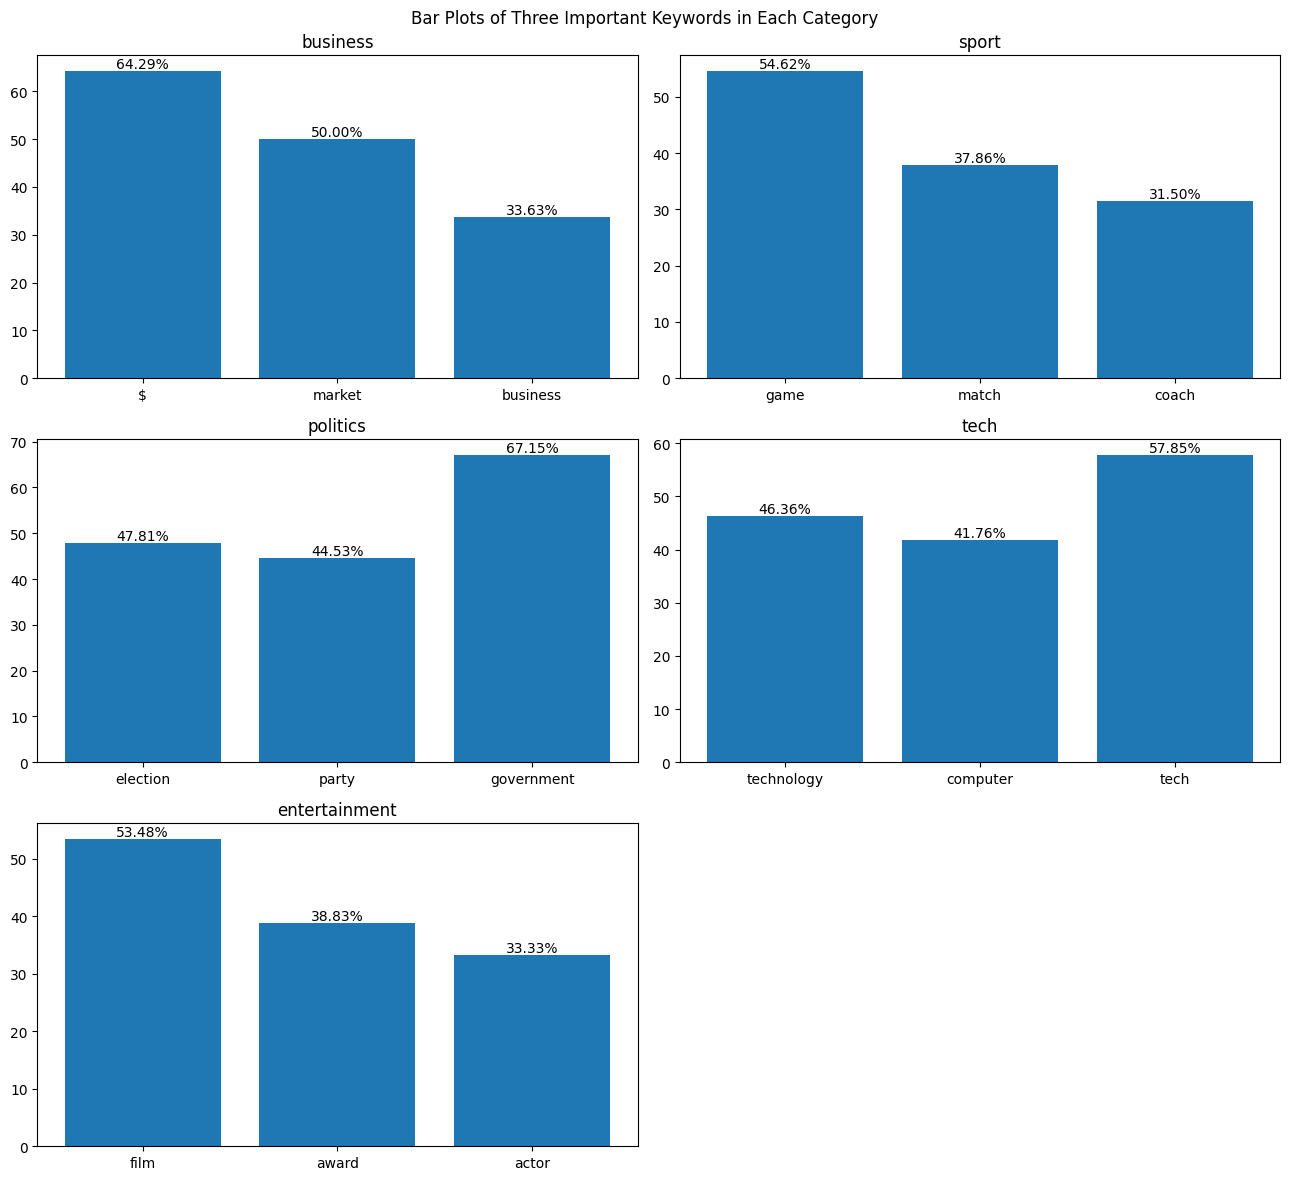

In [9]:
keywords = {
    "business": ["$", "market", "business"],
    "sport": ["game", "match", "coach"],
    "politics": ["election","party","government"],
    "tech":["technology","computer", "tech"],
    "entertainment":["film","award","actor"]
}

graph_per_row = 2
n_row = np.ceil(len(keywords) / graph_per_row).astype(int)
fig, axes = plt.subplots(n_row, graph_per_row, figsize=(13,12))
axes = axes.flatten()
for idx, category in enumerate(keywords):
    ax = axes[idx]
    category_mask = df["Category"] == category
    category_row = df[category_mask].shape[0]
    values = [
        (df[(category_mask) & (df["Text"].apply(lambda x : word in x))].shape[0] / category_row) * 100 for word in keywords[category]
    
    ]
    bar = ax.bar(keywords[category],values)
    for b in bar:
        height = b.get_height()
        ax.text(
            b.get_x() + b.get_width() / 2,
            height,                        
            f"{height:.2f}%",               
            ha="center",                  
            va="bottom"                    
        )
    ax.set_title(category)
    

if(n_row % graph_per_row != 0): #To remove unused subplots
    fig.delaxes(axes[len(keywords)])
fig.suptitle("Bar Plots of Three Important Keywords in Each Category")
fig.tight_layout()
plt.show()

- **The above graph exhibits the the percentage of each word appearing for each category. For instance, the dollar sign appears in 64.29% percent of the whole articles that are classified as business articles. On the other hand, the keyword *film* appears in 53.48% of the documents that are categorized as entertainment documents.**

- **It can be infferred from the above bars that these keywords will have a great influence on the naive bayes model to categorize different document as its inference is based on the count of each word.**

In [43]:
# Text Preprocessing
df_preprocessed = df.copy()
df_preprocessed["Text"] = df_preprocessed["Text"].apply(preprocess_text)

# Data Split
X, y = df_preprocessed["Text"], df_preprocessed["Category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
# Label Encoding
y_train = encode(y_train)
y_test = encode(y_test)

## Part 2 - Implementing Naive Bayes

### OUTLINE - Multinomial Naive Bayes

<h3>Training</h3>

- Create a matrix of the shape: $(n\_features \times n\_classes)$

**For each class $v_j$:**
- Compute[1]:

For unigram and bigram

\begin{equation}
    P(word_i | v_j) = \frac{\text{sum of count word in class} + \alpha}{\text{total count of all words in class} + \alpha * n\_features}
\end{equation}

For TF-IDF
\begin{equation}
    P(word_i | v_j) = \frac{\text{sum TF-IDF for word in class} + \alpha}{\text{total TF-IDF of all words in class} + \alpha * n\_features}
\end{equation}

- Add this to the main matrix:
\begin{equation}
    \begin{pmatrix}
            log(P(word_1| v_j)) \\
            log(P(word_2 | v_j)) \\
            \vdots                  \\
            log(P(word_n | v_j))   \\
    \end{pmatrix}
\end{equation}

<br /> <br />
\begin{equation} Final Matrix = 
    \begin{pmatrix}
            log(P(word_1| v_1))  & log(P(word_1| v_2))  & log(P(word_1| v_3))  & \cdots & log(P(word_1| v_m))       \\
            log(P(word_2 | v_1)) & log(P(word_2 | v_2)) & log(P(word_2 | v_3)) & \cdots & log(P(word_2 | v_m))      \\
            \vdots               & \vdots               & \vdots               & \ddots & \vdots                    \\
            log(P(word_n | v_1)) & log(P(word_n | v_2)) & log(P(word_n | v_3)) & \cdots & log(P(word_n | v_m))     \\
    \end{pmatrix}
\end{equation}

<h3>Testing</h3>

**For each sample in testing:**

- Compute[1]:
\begin{equation}
log[P(v_j) \times \prod_{i = 1}^{n\_features}{P(word_i | v_j)^{\text{TF-IDF}_i}}] = log(P(v_j)) + \sum_{i = 1}^{n\_features}{\text{TF-IDF}_i \times log(P(word_i | v_j))}
\end{equation}

- Pick the best jth column with the highest value.

- Get the corresponding jth category from the unique values of y as the predicted label. (Same logic as the first model)

In [45]:
class MultinomialNaiveBayes(BaseEstimator):
    """
    Class-based implementation of the Multinomial Naive Bayes (MNB).
    According to [1] and [2], MNB is a variation of Naive Bayes
    well known for text classification. Instead of using count
    probabilities of the form P(word = frequency | class) as seen
    in normal Naive Bayes, MNB sums all the frequency of one word
    given a class value. MNB assumes that each feature is multinomially
    distributed where the latter represents a generalization for the
    binomial distribution for cases with more than two discerete outcomes.[2]

    This class uses Laplace smoothing for consistency and to avoid
    the zero-probability problem. Naive Bayesian requires non-zero 
    probability.
    
    Parameters
    ----------
    alpha: int
        The smoothing parameter which acts as
        fake instances to each category.
        This is used in Laplace smoothing.

    prior: np.ndarray
        A 1D array that stores all of the prior
        probability P(class). The indices of this
        array are the same indices of the unique
        values of the target variable.

    likelihood_probabilities: 2D np.ndarray
      Stores the unconditional probabilities of the form 
      P(a_i | v_j) where a_i is the ith word and v_j is 
      the jth class value.
      The values are stored as log values for to save
      computational power in the testing phase.

    training_time: float
        The duration of the training phase.

    testing_time: float
        The duration of the testing phase.

    unique_y: np.ndarray
        A 1D array list to store the target variable classes
        of the given dataset.
    
    counts_y: np.ndarray
        A 1D array list to store the count of each
        class of the target variable of the given dataset.
            
    X: np.ndarray
        A matrix of the training data with shame (n_samples, n_features).

    y: np.ndarray
        A list of labels for the target variable.
        Shape: (n_samples,)

    Notes
    -----
    The X and y datasets are stored in this class to use them
    in feature importance.
    """
    def __init__(self, alpha = 1):
        self.alpha = alpha
        self.prior = None
        self.likelihood_probabilities = None
        self.training_time = 0
        self.testing_time = 0

    def _repr_html_(self):
        """ 
            To print the class in a good HTML style, similar to the sklearn one.

            Returns
            -------
            An HTML representation of the model for good display in Jupyter notebooks.
            It includes model title along with the model the arguments.
        """
        return estimator_html_repr(self)

    
    def fit(self, X, y):
        """
        Fit the model to the training data.
        
        Parameters
        ----------
        X: np.ndarray
            A matrix of the training data with shame (n_samples, n_features).

        y: np.ndarray
            A list of labels for the target variable.
            Shape: (n_samples,)
        """
        self.training_time = time.time()
        self.unique_y, self.counts_y = np.unique(y, return_counts=True)
        self.X = X
        self.y = y
    
        rows_y = y.shape[0]
        self.prior = np.log(np.maximum(self.counts_y / rows_y, 1e-9))  # Priori calculation
        self.likelihood_probabilities = self.calc_likelihood_probability(X, y)
        self.training_time = time.time() - self.training_time

    def calc_likelihood_probability(self, X, y):
        """
        Calculates the likelihood probabilities of each
        feature for each class.

        Parameters
        ----------
        X: np.ndarray
            A matrix of the training data

        y: np.ndarray
            A list of the labels

        Returns
        -------
        A 3D matrix with shape (n_features, n_classes, n_unique_values_feautre)

        Notes
        -----
        - A visualization of the steps of this method and the matrices
        in different phases of this method are shown above in the markdown
        cell below.
        """
        n_features = X.shape[1]
        n_classes = len(self.unique_y)
        log_probabilities = np.zeros((n_features, n_classes))
        for label_idx, label in enumerate(self.unique_y):
            mask = y == label
            X_filtered = X[mask]
            word_frequency_sum = np.sum(X_filtered, axis=0)
            total_word_frequency = np.sum(X_filtered)
            log_probabilities[:, label_idx] = np.log((word_frequency_sum + self.alpha) / (total_word_frequency + self.alpha * n_features))
        return log_probabilities

    def feature_importance(self, n_best):
        """
        To analyze the effect of the features (words)
        on prediction. It returns the n_best words whose
        presence most strongly classifies an article.
        It also gives the n_best words whose absence
        most strongly classifies an article.

        Parameters
        ----------
        n_best: int
            The n_best words whose presence or absence
            most strongly classifies an article.

        Returns
        -------
        A tuple
            - presence_indices: the indices of the n_best
            words whose presence most strongly classifies
            an article.
            - absence_indices: the indices of the n_best
            words whose absence most strongly classifies
            an article.
        """

        n_features = self.X.shape[1]
        n_classes = len(self.unique_y)
        not_v_j = np.zeros((n_features, n_classes))
        for label_idx, label in enumerate(self.unique_y):
            mask = self.y != label
            X_filtered = self.X[mask]
            word_frequency_sum = np.sum(X_filtered, axis=0)
            total_word_frequency = np.sum(X_filtered)
            not_v_j[:, label_idx] = np.log((word_frequency_sum + self.alpha) / (total_word_frequency + self.alpha * n_features))
        
        log_odds_presence = self.likelihood_probabilities - not_v_j
        presence_indices = np.argsort(log_odds_presence, axis=0)[-n_best:]

        
        log_odds_absence = np.log(-np.exp(self.likelihood_probabilities) + 1) # To reverse the log operation and then apply it again
        log_odds_absence = log_odds_absence - np.log(-np.exp(not_v_j) + 1)
        absence_indices = np.argsort(log_odds_absence, axis=0)[-n_best:]
        
        return (presence_indices, absence_indices)
            
    def predict(self, X):
        """
        Predict class labels for the input samples.

        Parameters
        ----------
        X: np.ndarray
            The input samples to predict.
        
        Returns
        -------
        y_pred: list
            A list of the predicted labels.

        Notes
        -----
        The steps of this method are visualized in more details
        in the above markdown cell.
        """
        y_pred = []
        n_classes = len(self.unique_y)
        for sample in X:
            tfidf_sample = np.tile(sample.reshape(-1,1), n_classes) # Shape = (n_features * n_classes)
            log_posterior = tfidf_sample * self.likelihood_probabilities
            log_posterior = self.prior + np.sum(log_posterior, axis=0) # P(class) + SUM_i(tfidf_i * P(word_i | class))
            predicted_label = self.unique_y[np.argmax(log_posterior)]
            y_pred.append(predicted_label)
        return np.array(y_pred)

In [46]:
def run_model(X_train, X_test):
    """
    A function to fit a model and predicted
    data.

    Parameters
    ----------
    X_train: np.ndarray
        The training data

    X_test: np.ndarray
        The test data

    Returns
    -------
    The accuracy score of the model.
    """
    nb = MultinomialNaiveBayes()
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    presence, absence = nb.feature_importance(10)
    return (accuracy_score(y_pred, y_test), presence, absence)

#### Optimal parameter for Count Vectorizer

- **Count Vectorizer class comes with a threshold parameter called min_df. The BoW model will ignore words that have a document frequency stricly lower than the given threshold. This is used as a pre-processing step to discard unimportant words, prune the BoW model, and reduce dimensionality. This will not affect stopwords, as stopwords must have higher frequency than the specificed threshold.**
- **This pre-processing was only applied to unigram and TF-IDF with and without stopwords. It was not applied to bigram as it negatively affected accuracy score.**
- **This part will run different thresholds and choose the best optimal one with the best accuracy score**

In [47]:
thresholds = list(range(5,21))

In [48]:
scores_unigram = []
for k in thresholds:
    print(k, end=" - ")
    
    unigram_vectorizer = CountVectorizer(ngram_range=(1,1), min_df=k)

    X_train_unigram = unigram_vectorizer.fit_transform(X_train).toarray()
    X_test_unigram = unigram_vectorizer.transform(X_test).toarray()
    
    scores_unigram.append(run_model(X_train_unigram, X_test_unigram)[0])
print()

5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20 - 


The Optimal min_df Value for Unigram is 11.


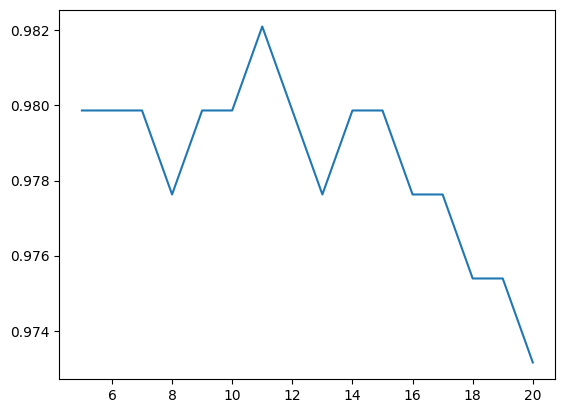

In [49]:
min_df_unigram = thresholds[np.argmax(scores_unigram)]
print("============================================")
print(f"The Optimal min_df Value for Unigram is {min_df_unigram}.")
print("============================================")
plt.plot(thresholds , scores_unigram)
plt.show()

In [50]:
unigram_vectorizer = CountVectorizer(ngram_range=(1,1))
bigram_vectorizer = CountVectorizer(ngram_range=(2,2))

X_train_unigram = unigram_vectorizer.fit_transform(X_train).toarray()
X_test_unigram = unigram_vectorizer.transform(X_test).toarray()

X_train_bigram = bigram_vectorizer.fit_transform(X_train).toarray()
X_test_bigram = bigram_vectorizer.transform(X_test).toarray()

feature_names_unigram = np.array(unigram_vectorizer.get_feature_names_out())
feature_names_bigram = np.array(bigram_vectorizer.get_feature_names_out())

y_train = np.array(y_train)
y_test = np.array(y_test)

In [51]:
print("======================")
print("Unigram Dataset Shapes")
print("======================")
print(X_train_unigram.shape)
print(X_test_unigram.shape)
print("=====================")
print("Bigram Dataset Shapes")
print("=====================")
print(X_train_bigram.shape)
print(X_test_bigram.shape)

Unigram Dataset Shapes
(1043, 20125)
(447, 20125)
Bigram Dataset Shapes
(1043, 180179)
(447, 180179)


- **Both the training set and test set have the same set of features, or same set of words. While it is possible that both datasets may not have the same set of words in their articles, the CountVectorizer ensures that X_test has the same vocabulary learned from X_train to ensure consistency. As a result, transforming the testing datasets with the same CountVectorizer used for the training datasets is crucial.**
- **Bigram has more features (words) than unigram. As a result, it is likely that the accuracy scores of bigrams will be lower than unigram Naive Bayes.**

In [52]:
unigram_accuracy, n_best_presence_unigram, n_best_absence_unigram = run_model(X_train_unigram, X_test_unigram)
print(f"Accuracy Score for Unigram: {unigram_accuracy}")

bigram_accuracy, n_best_presence_bigram, n_best_absence_bigram = run_model(X_train_bigram, X_test_bigram)
print(f"Accuracy Score for Bigram: {bigram_accuracy}")

Accuracy Score for Unigram: 0.9776286353467561
Accuracy Score for Bigram: 0.970917225950783



## Analyzing the effect of the words on prediction

In [53]:
# 10 words whose presence most strongly predicts that the article belongs to a specific category for each five categories.
print("=======================================")
print("              Unigram BoW")
print("=======================================")
print()
print("The 10 best words whose presence most strongly predicts for:")
print("------------------------------------------------------------")
for category_idx, category in enumerate(np.unique(y)):
    print(f"{category} category are: {feature_names_unigram[n_best_presence_unigram[:, category_idx]]}", end="\n\n")

print("The 10 best words whose absence most strongly predicts for:")
print("------------------------------------------------------------")
for category_idx, category in enumerate(np.unique(y)):
    print(f"{category} category are: {feature_names_unigram[n_best_absence_unigram[:, category_idx]]}", end="\n\n")


print("=======================================")
print("                Bigram BoW")
print("=======================================")
print("The 10 best words whose presence most strongly predicts for:")
print("------------------------------------------------------------")
for category_idx, category in enumerate(np.unique(y)):
    print(f"{category} category are: {feature_names_bigram[n_best_presence_bigram[:, category_idx]]}", end="\n\n")

print("The 10 best words whose absence most strongly predicts for:")
print("------------------------------------------------------------")
for category_idx, category in enumerate(np.unique(y)):
    print(f"{category} category are: {feature_names_bigram[n_best_absence_bigram[:, category_idx]]}", end="\n\n")

              Unigram BoW

The 10 best words whose presence most strongly predicts for:
------------------------------------------------------------
business category are: ['boerse' 'currency' 'khodorkovsky' 'worldcom' 'rosneft' 'creditors'
 'gazprom' 'lse' 'imf' 'yukos']

entertainment category are: ['comedy' 'oscars' 'foxx' 'oscar' 'singer' 'nominations' 'aviator'
 'festival' 'actress' 'album']

politics category are: ['blunkett' 'dem' 'kennedy' 'dems' 'ukip' 'asylum' 'lords' 'lib' 'tory'
 'tories']

sport category are: ['striker' 'mourinho' 'federer' 'conte' 'henman' 'wenger' 'athens' 'slam'
 'nadal' 'roddick']

tech category are: ['handsets' 'gadget' 'multimedia' 'xbox' 'users' 'portable' 'spam'
 'gadgets' 'mobiles' 'devices']

The 10 best words whose absence most strongly predicts for:
------------------------------------------------------------
business category are: ['they' 'for' 'but' 'be' 'was' 'his' 'to' 'he' 'and' 'the']

entertainment category are: ['be' 'it' 'and' 'in' 'sa

**Top 10 words (presence)**:
- **There were highly specific words for each category in Unigram BoW. For instance, there were very specific financial and corporate vocabulary such as *currency* and *khodorkovsky* who is a russan businessman.**
- **The bigram model captured the 10 most important phrases that depicts a speicifc categorization for a document. In fact, conceptually speaking, the terms inferred in bigram were much less ambigious and more domain specific. A good illustration for this is the tech category most important 10 words such as "the mac" and "the software".**
- **A lot of the bigram most important phrases are actually accompanied by a *stopword* such as the, of, and his. As a result removing stopwords might in fact negatively affect bigram performance as they are crucial to classify a specific document. Their role in the bigram-based MNB classifier relies in preserving context.**

**Top 10 words (absence)**:
- **For unigram BoW, these words were mainly stopwords such as they, for, at, etc.**
- **For bigram BoW, these words were also mainly stopwords such as they, for, at, etc. Aside from this, they were also some phrases that did not fit the specified category such as "the goverment" in the tech category.**

## Part 3 - TF-IDF + Stopwords

### TF-IDF

In [54]:
# Picking the best optimal min_df
scores_tfidf = []
for k in thresholds:
    print(k, end=" - ")
    tfidf = TfidfVectorizer(min_df=k)
    X_tfidf_train = tfidf.fit_transform(X_train).toarray()
    X_tfidf_test = tfidf.transform(X_test).toarray()
    scores_tfidf.append(run_model(X_tfidf_train, X_tfidf_test)[0])
print()

5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20 - 


The optimal min_df value for TFIDF is 13.


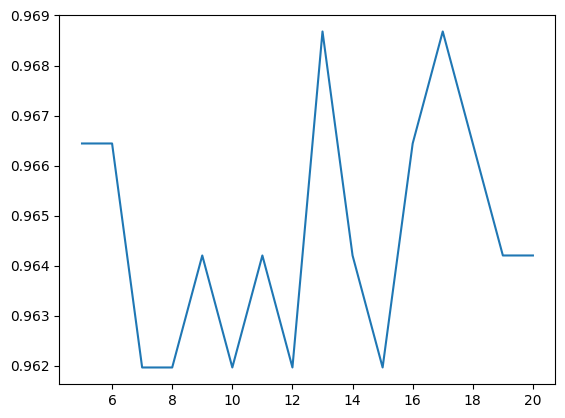

In [55]:
max_k = thresholds[np.argmax(scores_tfidf)]
print(f"The optimal min_df value for TFIDF is {max_k}.")
plt.plot(thresholds, scores_tfidf)
plt.show()

In [56]:
tfidf = TfidfVectorizer()
X_tfidf_train = tfidf.fit_transform(X_train).toarray()
X_tfidf_test = tfidf.transform(X_test).toarray()

In [57]:
accuracy_score_tfidf, n_best_presence_tfidf, n_best_absence_tfidf = run_model(X_tfidf_train, X_tfidf_test)
print(f"The accuracy score for TF-IDF without stopwords is: {accuracy_score_tfidf:.3f}")

The accuracy score for TF-IDF without stopwords is: 0.957


In [58]:
feature_names_tfidf = np.array(tfidf.get_feature_names_out())
# 10 words whose presence most strongly predicts that the article belongs to a specific category for each five categories.
print("======================")
print("The 10 best words whose presence most strongly predicts:")
for category_idx, category in enumerate(np.unique(y)):
    print(f"{category} are: {feature_names_tfidf[n_best_presence_tfidf[:, category_idx]]}", end="\n\n")

print("======================")
print("The 10 best words whose absence most strongly predicts:")
for category_idx, category in enumerate(np.unique(y)):
    print(f"{category} are: {feature_names_tfidf[n_best_absence_tfidf[:, category_idx]]}", end="\n\n")


The 10 best words whose presence most strongly predicts:
business are: ['imf' 'economic' 'profits' 'stock' 'deficit' 'growth' 'bank' 'shares'
 'oil' 'yukos']

entertainment are: ['musical' 'actress' 'comedy' 'oscar' 'singer' 'festival' 'album' 'actor'
 'band' 'film']

politics are: ['ukip' 'secretary' 'kennedy' 'tory' 'lib' 'tories' 'party' 'blair'
 'election' 'labour']

sport are: ['season' 'olympic' 'rugby' 'champion' 'arsenal' 'injury' 'match' 'coach'
 'chelsea' 'cup']

tech are: ['spam' 'mobiles' 'phones' 'virus' 'computer' 'broadband' 'microsoft'
 'mobile' 'users' 'software']

The 10 best words whose absence most strongly predicts:
business are: ['on' 'his' 'is' 'for' 'he' 'in' 'of' 'and' 'to' 'the']

entertainment are: ['he' 'it' 'said' 'is' 'that' 'in' 'and' 'of' 'to' 'the']

politics are: ['that' 'on' 'is' 'for' 'it' 'of' 'and' 'in' 'to' 'the']

sport are: ['it' 'for' 'is' 'that' 'said' 'in' 'and' 'of' 'to' 'the']

tech are: ['on' 'said' 'his' 'for' 'he' 'of' 'and' 'in' 'to' 't

**10 best words (presence)**:
- **While similar words are shared between the TF-IDF and unigram based MNB classifier, the vocabulary employed in TF-IDF is more general and context-specific rather the dependency of the unigram model on specific words such as the specific names of businessmen. However, TF-IDF feature importance exhibits words that fall into the lexicl field of each category creating a balance between context-specific and abstract terms. For instance, the TF-IDF entertainment words are general terms such as musical, actress, or film. However, in the unigram entertainment category, Foxx was displayed, probably referring to the american actor Jamie Fox.**

**10 best words (absence)**:
- **Similar behavior is exhibited between TF-IDF and the previous models where all of these words are actually stopwords.**

### Stopwords

In [59]:
scores_unigram_stopwords = []
for k in thresholds:
    print(k, end=" - ")
    unigram_vectorizer = CountVectorizer(ngram_range=(1,1), min_df=k, stop_words=list(ENGLISH_STOP_WORDS))
    X_train_unigram = unigram_vectorizer.fit_transform(X_train).toarray()
    X_test_unigram = unigram_vectorizer.transform(X_test).toarray()
    scores_unigram_stopwords.append(run_model(X_train_unigram, X_test_unigram)[0])
print()

5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20 - 


The optimal min_df value for unigram with stopwords is 9.


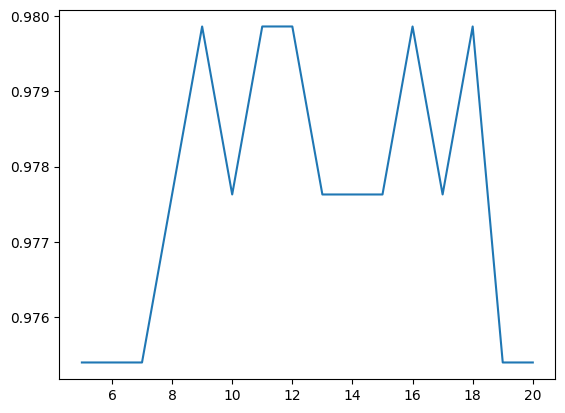

In [60]:
min_df_unigram_stopwords = thresholds[np.argmax(scores_unigram_stopwords)]
print(f"The optimal min_df value for unigram with stopwords is {min_df_unigram_stopwords}.")
plt.plot(thresholds , scores_unigram_stopwords)
plt.show()

In [61]:
unigram_stopwrods_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer="word", stop_words=list(ENGLISH_STOP_WORDS))
bigram_stopwords_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer="word", stop_words=list(ENGLISH_STOP_WORDS))

X_train_unigram_stopwords = unigram_stopwrods_vectorizer.fit_transform(X_train).toarray()
X_test_unigram_stopwords = unigram_stopwrods_vectorizer.transform(X_test).toarray()

X_train_bigram_stopwords = bigram_stopwords_vectorizer.fit_transform(X_train).toarray()
X_test_bigram_stopwords = bigram_stopwords_vectorizer.transform(X_test).toarray()

features_names_unigram_stopwords = unigram_stopwrods_vectorizer.get_feature_names_out()
feature_names_bigram_stopwords = bigram_stopwords_vectorizer.get_feature_names_out()

In [62]:
unigram_stopwords_accuracy, n_best_presence_unigram_stop, n_best_absence_unigram_stop = run_model(X_train_unigram_stopwords, X_test_unigram_stopwords)
print(f"Accuracy Score for Unigram with Stopwords: {unigram_stopwords_accuracy}")

Accuracy Score for Unigram with Stopwords: 0.9753914988814317


In [63]:
feature_names_unigram_stopwords = unigram_stopwrods_vectorizer.get_feature_names_out()
# 10 words whose presence most strongly predicts that the article belongs to a specific category for each five categories.
print("==========================================")
print("        Unigram BoW with stopwords")
print("==========================================")
print("The 10 best non-stopwords that most strongly predict that the article belongs to specific category for each five categories:")
for category_idx, category in enumerate(np.unique(y)):
    print(f"{category} are: {feature_names_unigram_stopwords[n_best_presence_unigram_stop[:, category_idx]]}", end="\n\n")

        Unigram BoW with stopwords
The 10 best non-stopwords that most strongly predict that the article belongs to specific category for each five categories:
business are: ['boerse' 'currency' 'worldcom' 'khodorkovsky' 'rosneft' 'creditors'
 'gazprom' 'lse' 'imf' 'yukos']

entertainment are: ['comedy' 'oscars' 'foxx' 'oscar' 'singer' 'nominations' 'aviator'
 'festival' 'actress' 'album']

politics are: ['blunkett' 'dem' 'kennedy' 'dems' 'ukip' 'asylum' 'lords' 'lib' 'tory'
 'tories']

sport are: ['federer' 'striker' 'mourinho' 'conte' 'wenger' 'henman' 'athens' 'slam'
 'nadal' 'roddick']

tech are: ['handsets' 'gadget' 'multimedia' 'xbox' 'users' 'portable' 'spam'
 'gadgets' 'mobiles' 'devices']



- **There was not distinguishable change between the results of Unigram with and without stopwords. In fact, all of the non-stopwords were shared between both. Building upon the previous results, it can be deduced that stopwords were neutral across all categories with the Unigram BoW model since their removal did not lead to an improvement or a noticeable decrease in performance. This suggests that the model was very effective in classifying articles based on single words. Further improvement can be taken such as lemmatization such as transforming *creditors* to *creditor* in the business category.**

In [64]:
bigram_stopwrods_accuracy, n_best_presence_bigram_stop, n_best_absence_bigram_stop = run_model(X_train_bigram_stopwords, X_test_bigram_stopwords)
print(f"Accuracy Score for Bigram with Stopwords: {bigram_stopwrods_accuracy}")

Accuracy Score for Bigram with Stopwords: 0.959731543624161


In [65]:
feature_names_bigram_stopwords = bigram_stopwords_vectorizer.get_feature_names_out()
# 10 words whose presence most strongly predicts that the article belongs to a specific category for each five categories.
print("==========================================")
print("         Bigram BoW with stopwords")
print("==========================================")
print("The 10 best non-stopwords that most strongly predict that the article belongs to specific category for each five categories:")
for category_idx, category in enumerate(np.unique(y)):
    print(f"{category} are: {feature_names_bigram_stopwords[n_best_presence_bigram_stop[:, category_idx]]}", end="\n\n")

         Bigram BoW with stopwords
The 10 best non-stopwords that most strongly predict that the article belongs to specific category for each five categories:
business are: ['russian government' 'standard chartered' 'deutsche bank'
 'fourth quarter' 'economic growth' 'oil giant' 'consumer spending'
 'oil prices' 'deutsche boerse' 'stock market']

entertainment are: ['best supporting' 'best actress' 'vera drake' 'best director'
 'jamie foxx' 'best actor' 'million dollar' 'dollar baby' 'named best'
 'box office']

politics are: ['lord goldsmith' 'foreign secretary' 'tory leader' 'kilroy silk'
 'lib dem' 'blair said' 'lib dems' 'liberal democrats' 'michael howard'
 'home secretary']

sport are: ['andy roddick' 'french open' 'drugs test' 'cross country' 'fly half'
 'olympic champion' 'champions league' 'davis cup' 'australian open'
 'grand slam']

tech are: ['desktop search' 'people using' 'internet explorer' 'music players'
 'digital cameras' 'mobile phone' 'hard drive' 'high definition'

- **As predicted before, the Bigram BoW with stopwords based MNB classifier had a slight decrease in performance exhibited in a lower accuracy score, from 0.97 to 0.96. Previously the Bigram expression highly used stopwords in their most important phrases to classify a document in a speciic category. Some of these phrases are *the chancelor,* *the england,* and *the prime.* These stopwords were adding more context and importance to keywords directly and clearly related to their own categories. As a result, the first MNB was able to highlight and unveil the hidden patterns in language syntax and structure to convey specific topics (categories). In such cases, it unecessary, even harmful, to remove stopwords. However, analysis along with trial and testing must be conducted to reach and verify such conclusions.**

In [66]:
scores_tfidf_stopwords = []
for k in thresholds:
    print(k, end=" - ")
    tfidf = TfidfVectorizer(min_df=k, stop_words=list(ENGLISH_STOP_WORDS))
    X_tfidf_train = tfidf.fit_transform(X_train).toarray()
    X_tfidf_test = tfidf.transform(X_test).toarray()
    scores_tfidf_stopwords.append(run_model(X_tfidf_train, X_tfidf_test)[0])
print()

5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20 - 


The optimal min_df value for TFIDF is 5.


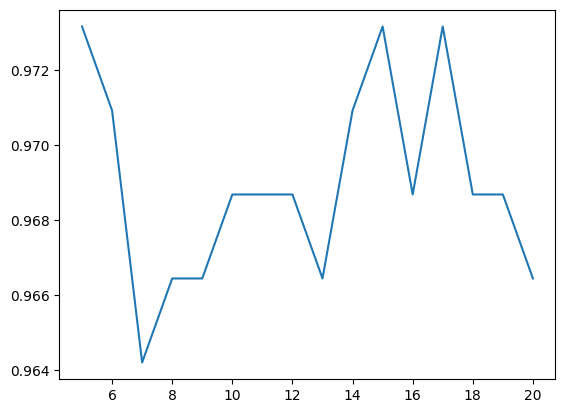

In [67]:
min_df_tfidf_stopwords = thresholds[np.argmax(scores_tfidf_stopwords)]
print(f"The optimal min_df value for TFIDF is {min_df_tfidf_stopwords}.")
plt.plot(thresholds , scores_tfidf_stopwords)
plt.show()

In [68]:
tfidf_stopwords = TfidfVectorizer(stop_words=list(ENGLISH_STOP_WORDS))
X_tfidf_stopwords_train = tfidf_stopwords.fit_transform(X_train).toarray()
X_tfidf_stopwords_test = tfidf_stopwords.transform(X_test).toarray()
accuracy_score_tfidf_stopwords, n_presence_tfidf_stopwords, n_absence_tfidf_stopwords= run_model(X_tfidf_stopwords_train,X_tfidf_stopwords_test)
print(f"Accuracy Score for TF-IDF with Stopwords is: {accuracy_score_tfidf_stopwords:.3f}")

Accuracy Score for TF-IDF with Stopwords is: 0.969


In [69]:
feature_names_tfidf_stopwords = tfidf_stopwords.get_feature_names_out()
# 10 words whose presence most strongly predicts that the article belongs to a specific category for each five categories.
print("==========================================")
print("          TF-IDF with stopwords")
print("==========================================")
print("The 10 best non-stopwords that most strongly predict that the article belongs to specific category for each five categories:")
for category_idx, category in enumerate(np.unique(y)):
    print(f"{category} are: {feature_names_tfidf_stopwords[n_presence_tfidf_stopwords[:, category_idx]]}", end="\n\n")

          TF-IDF with stopwords
The 10 best non-stopwords that most strongly predict that the article belongs to specific category for each five categories:
business are: ['imf' 'economic' 'profits' 'stock' 'growth' 'deficit' 'bank' 'shares'
 'oil' 'yukos']

entertainment are: ['musical' 'actress' 'comedy' 'oscar' 'singer' 'festival' 'album' 'actor'
 'band' 'film']

politics are: ['secretary' 'lords' 'kennedy' 'tory' 'lib' 'tories' 'party' 'blair'
 'election' 'labour']

sport are: ['roddick' 'olympic' 'rugby' 'match' 'champion' 'injury' 'arsenal' 'coach'
 'chelsea' 'cup']

tech are: ['spam' 'phones' 'mobiles' 'virus' 'computer' 'microsoft' 'broadband'
 'mobile' 'users' 'software']



- **Interetingly, the removal of stopwords increased accuracy score from 0.96 to 0.97 for TF-IDF. This is consequently due to the natural properties of TF-IDF that downweights the importance of highly occurent words. The main principle is that very highly repeated words are usually not important as they do not convey uniqueness to distinguish between conceptually different documents. On the other hand, TF-IDF increased the importance of rarely occurent words in a document as those are the unique identifiers and keywords that are in coherence with the category of the document. Before the removal of stopwords, the latter have not played an important role in classifiying documents. As a result, removing them here was very useful since TF-IDF stripped them of their inherent high frequency. Aside from this, the removal of stopwords led to dimensionality reduction here by removing a large size of the vocabulary.**

## Part 4 - Calculation of Accuracy

In [70]:
# Summary
print(f"Accuracy Score for Unigram: {unigram_accuracy:.3f}")
print(f"Accuracy Score for Bigram: {bigram_accuracy:.3f}")
print(f"The accuracy score for TF-IDF without stopwords is: {accuracy_score_tfidf:.3f}")
print(f"Accuracy Score for Unigram with Stopwords: {unigram_stopwords_accuracy:.3f}")
print(f"Accuracy Score for Bigram with Stopwords: {bigram_stopwrods_accuracy:.3f}")
print(f"Accuracy Score for TF-IDF with Stopwords is: {accuracy_score_tfidf_stopwords:.3f}")

Accuracy Score for Unigram: 0.978
Accuracy Score for Bigram: 0.971
The accuracy score for TF-IDF without stopwords is: 0.957
Accuracy Score for Unigram with Stopwords: 0.975
Accuracy Score for Bigram with Stopwords: 0.960
Accuracy Score for TF-IDF with Stopwords is: 0.969


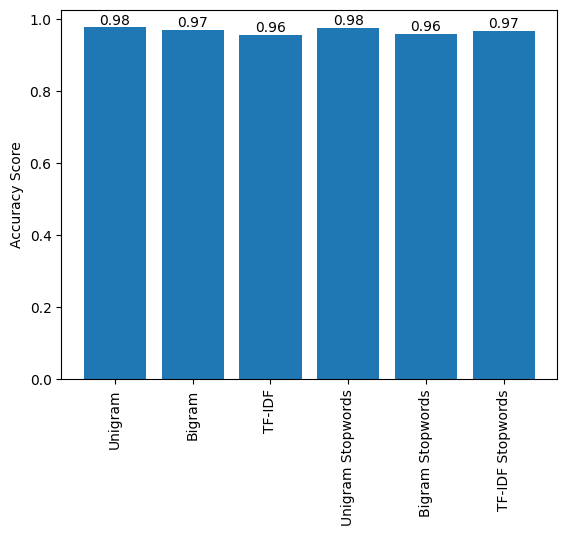

In [71]:
accuracies = {
    "Unigram": unigram_accuracy,
    "Bigram":bigram_accuracy,
    "TF-IDF": accuracy_score_tfidf,
    "Unigram Stopwords":unigram_stopwords_accuracy,
    "Bigram Stopwords": bigram_stopwrods_accuracy,
    "TF-IDF Stopwords": accuracy_score_tfidf_stopwords
}

bar = plt.bar(list(accuracies.keys()), list(accuracies.values()))
for b in bar:
    height = b.get_height()
    plt.text(
        b.get_x() + b.get_width() / 2,
        height,                        
        f"{height:.2f}",               
        ha="center",                  
        va="bottom"                    
    )
plt.xticks(rotation=90)
plt.ylabel("Accuracy Score")
plt.show()

- **This bar plot summarizes the different accuracy scores of every experiment deduced in this assignment.**
- **Unigram with and without stopwords both achieved the highest accuracy score compared to all models. As a result, single words classification was very effective with the current implemented mode.**
- **Bigram performed less than Unigram reaching an accuracy score of 0.97. This can be mainly due to the high dimensionality Bigram BoW model induces resulting in data sparsity as the number of samples are much less than that of the features (words). Bigram Stopwords on the otherhand performed the worst compared to all models, with a score of 0.96. While the score is very high, this drop in accuracy and rank of this model is due to the dependency of MNB algorithm on phrases followed by stopwords, specifically defining english articles such as "the" which added more context and more emphasis on those crucial phrases. It is important to note that the BoW model removed a lot of phrases (noise) purely made out of stopwords.**
- **TF-IDF performed very well but not as high as the rest of the models. As seen in the first section of this assignment, some of the most important words that are related to each category are highly frequent in each category. While the majority only frequently occured in their corresponding categories, TF-IDF might have decreased their importance. Furthermore, with the power of TF-IDF downweighting the importance of noise such as some repeated stopwords and increasing the importance of other words, the accuracy from 0.96 to 0.97 with the removal of stopwords.**

# Resources

- **[1]https://www.geeksforgeeks.org/machine-learning/multinomial-naive-bayes/**
- **[2]S. Sinharay, Discrete Probability Distributions,Editor(s): Penelope Peterson, Eva Baker, Barry McGaw, International Encyclopedia of Education (Third Edition), Elsevier, 2010, Pages 132-134, ISBN 9780080448947,**
- **[3]https://www.geeksforgeeks.org/machine-learning/understanding-tf-idf-term-frequency-inverse-document-frequency/**
- **[4]https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html**
- **[5]https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html**
- **[6]https://www.statisticshowto.com/log-odds/**